# KDD Cup 1999 - Binary Saldırı Tespiti

Bu notebook, KDD Cup 1999 veri seti ile binary sınıflandırma (saldırı vs normal) modellerini geliştirir.

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score

from src.data import load_kdd
from src.preprocess import add_targets, split_features
from src.models import make_binary_pipelines
from src.eval import plot_roc_pr, plot_cm, find_best_threshold

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Veri Hazırlama

In [2]:
# Veri yükleme
train_raw = load_kdd('../data/kddcup.data_10_percent.gz')
test_raw = load_kdd('../data/corrected.gz')

# Hedef değişkenleri ekleme
train_df = add_targets(train_raw)
test_df = add_targets(test_raw)

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

# Hızlı test için veri setini küçültme (ilk 50,000 örnek)
from sklearn.model_selection import train_test_split
train_df_small, _ = train_test_split(train_df, test_size=0.9, random_state=42, stratify=train_df['y_binary'])
test_df_small, _ = train_test_split(test_df, test_size=0.9, random_state=42, stratify=test_df['y_binary'])

print(f'\nSmall train shape: {train_df_small.shape}')
print(f'Small test shape: {test_df_small.shape}')

# Binary hedef dağılımı
print('\nBinary target distribution (small train):')
print(train_df_small['y_binary'].value_counts())
print('\nBinary target distribution (small test):')
print(test_df_small['y_binary'].value_counts())

Train shape: (494021, 45)
Test shape: (311029, 45)



Small train shape: (49402, 45)
Small test shape: (31102, 45)

Binary target distribution (small train):
y_binary
1    39674
0     9728
Name: count, dtype: int64

Binary target distribution (small test):
y_binary
1    25043
0     6059
Name: count, dtype: int64


In [3]:
# Özellik ayrımı (küçük veri seti kullanarak)
X_train, y_train_bin, y_train_multi, num_cols, cat_cols = split_features(train_df_small)
X_test, y_test_bin, y_test_multi, _, _ = split_features(test_df_small)

print(f'Feature shape: {X_train.shape}')
print(f'Binary target shape: {y_train_bin.shape}')
print(f'Multi-class target shape: {y_train_multi.shape}')

Feature shape: (49402, 41)
Binary target shape: (49402,)
Multi-class target shape: (49402,)


## 2. Model Pipeline'ları

In [4]:
# Model pipeline'ları ve hiperparametre gridleri
grids = make_binary_pipelines(num_cols, cat_cols)

print('Available models:')
for name in grids.keys():
    print(f'- {name}')

Available models:
- lr
- rf


## 3. Model Eğitimi ve Hiperparametre Optimizasyonu

In [5]:
# Cross-validation stratejisi (hızlı test için 2 split)
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Eğitilmiş modelleri saklama
trained_models = {}

In [6]:
# Logistic Regression
print('=== Logistic Regression ===')
name = 'lr'
pipe, param_grid = grids[name]

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train_bin)
trained_models[name] = search.best_estimator_

print(f'Best params: {search.best_params_}')
print(f'Best CV score: {search.best_score_:.4f}')

=== Logistic Regression ===
Fitting 2 folds for each of 2 candidates, totalling 4 fits


Best params: {'classifier__C': 1}
Best CV score: 0.9987


In [7]:
# Random Forest
print('\n=== Random Forest ===')
name = 'rf'
pipe, param_grid = grids[name]

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train_bin)
trained_models[name] = search.best_estimator_

print(f'Best params: {search.best_params_}')
print(f'Best CV score: {search.best_score_:.4f}')


=== Random Forest ===
Fitting 2 folds for each of 4 candidates, totalling 8 fits


Best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best CV score: 0.9996


## 4. Model Performans Karşılaştırması

In [8]:
# Test seti performansları
results = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    f1 = f1_score(y_test_bin, y_pred)
    auc = roc_auc_score(y_test_bin, y_proba)
    
    results[name] = {
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_proba
    }
    
    print(f'\n=== {name.upper()} ===')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {auc:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test_bin, y_pred))


=== LR ===
F1 Score: 0.9498
ROC AUC: 0.9706

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      6059
           1       1.00      0.91      0.95     25043

    accuracy                           0.92     31102
   macro avg       0.86      0.95      0.89     31102
weighted avg       0.94      0.92      0.93     31102




=== RF ===
F1 Score: 0.9524
ROC AUC: 0.9795

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      6059
           1       1.00      0.91      0.95     25043

    accuracy                           0.93     31102
   macro avg       0.86      0.95      0.90     31102
weighted avg       0.95      0.93      0.93     31102



In [9]:
# En iyi modeli seçme
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = trained_models[best_model_name]

print(f'En iyi model: {best_model_name}')
print(f'F1 Score: {results[best_model_name]["f1"]:.4f}')
print(f'ROC AUC: {results[best_model_name]["auc"]:.4f}')

En iyi model: rf
F1 Score: 0.9524
ROC AUC: 0.9795


## 5. En İyi Modelin Detaylı Analizi

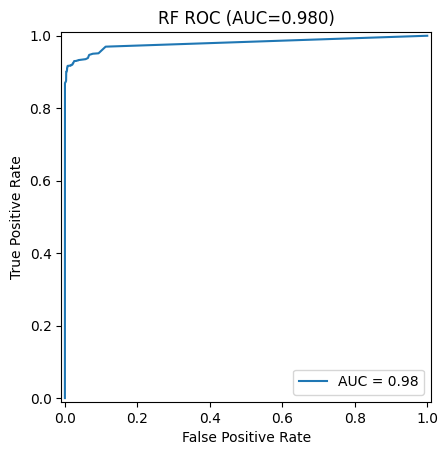

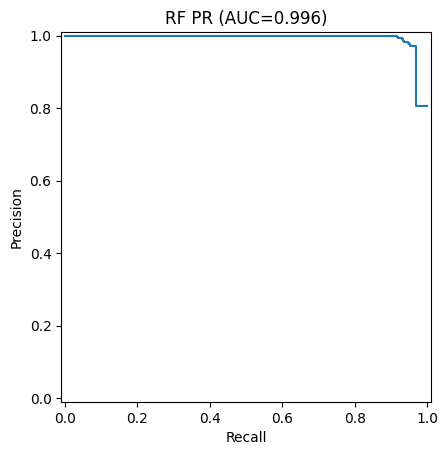

In [10]:
# ROC ve Precision-Recall eğrileri
y_proba_best = results[best_model_name]['probabilities']
plot_roc_pr(y_test_bin, y_proba_best, title_prefix=f'{best_model_name.upper()}')

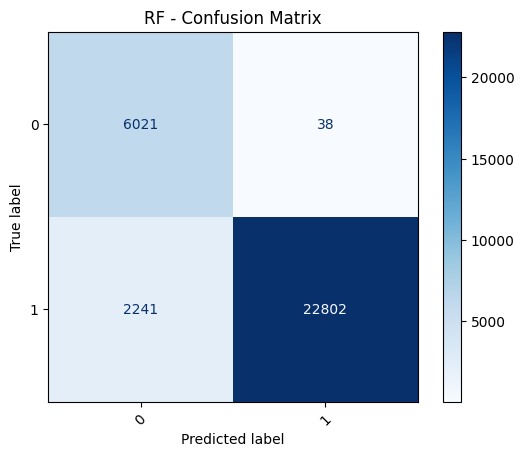

In [11]:
# Karışıklık matrisi
y_pred_best = results[best_model_name]['predictions']
plot_cm(y_test_bin, y_pred_best, title=f'{best_model_name.upper()} - Confusion Matrix')

## 6. Eşik Optimizasyonu

In [12]:
# En iyi F1 skorunu veren eşiği bulma
best_threshold, best_f1 = find_best_threshold(y_test_bin, y_proba_best)

print(f'En iyi eşik: {best_threshold:.4f}')
print(f'En iyi F1 skoru: {best_f1:.4f}')

# Optimized predictions
y_pred_optimized = (y_proba_best >= best_threshold).astype(int)

print('\nOptimized Classification Report:')
print(classification_report(y_test_bin, y_pred_optimized))

En iyi eşik: 0.1100
En iyi F1 skoru: 0.9607

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      6059
           1       0.99      0.93      0.96     25043

    accuracy                           0.94     31102
   macro avg       0.88      0.95      0.91     31102
weighted avg       0.95      0.94      0.94     31102



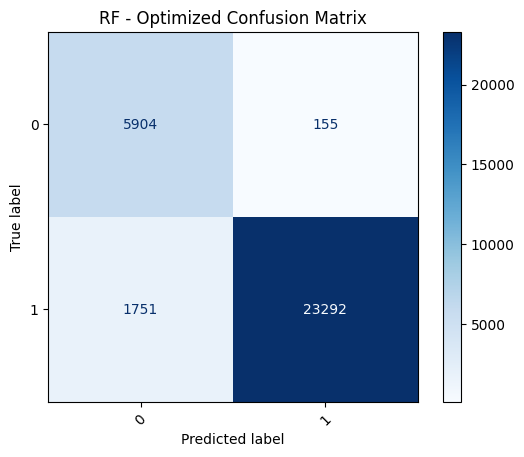

In [13]:
# Optimized karışıklık matrisi
plot_cm(y_test_bin, y_pred_optimized, title=f'{best_model_name.upper()} - Optimized Confusion Matrix')

## 7. Özellik Önemleri (Random Forest için)

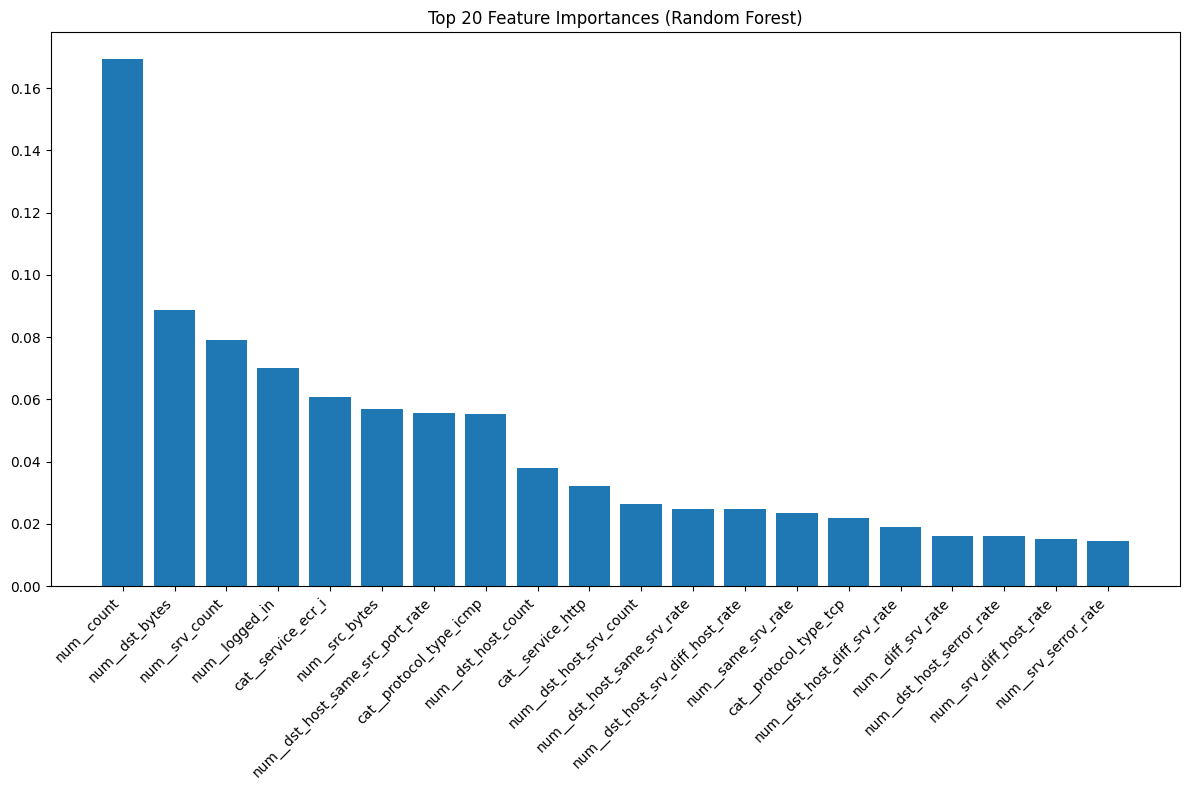

Top 10 Most Important Features:
 1. num__count                     0.1694
 2. num__dst_bytes                 0.0887
 3. num__srv_count                 0.0790
 4. num__logged_in                 0.0700
 5. cat__service_ecr_i             0.0608
 6. num__src_bytes                 0.0569
 7. num__dst_host_same_src_port_rate 0.0555
 8. cat__protocol_type_icmp        0.0551
 9. num__dst_host_count            0.0380
10. cat__service_http              0.0323


In [14]:
# Random Forest özellik önemleri
if 'rf' in trained_models:
    rf_model = trained_models['rf']
    
    # Pipeline'dan Random Forest'i çıkarma
    rf_classifier = rf_model.named_steps['classifier']
    
    # Özellik isimleri (preprocessing sonrası)
    feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
    
    # Özellik önemleri
    importances = rf_classifier.feature_importances_
    
    # En önemli 20 özellik
    indices = np.argsort(importances)[::-1][:20]
    
    plt.figure(figsize=(12, 8))
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.bar(range(20), importances[indices])
    plt.xticks(range(20), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print('Top 10 Most Important Features:')
    for i in range(10):
        idx = indices[i]
        print(f'{i+1:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}')